In [5]:

import importlib
import shiftNMF_frozen
importlib.reload(shiftNMF_frozen)
from shiftNMF_frozen import ShiftNMF
#from shiftNMFDiscTau import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *
from helpers.data import X_ART, X_ART_NOISY, TAU_ART, W_ART, H_ART
from Hardmodel_single_peaks import Single_Model
from Hardmodel import Hard_Model
import scipy
from scipy.signal import find_peaks
import itertools
from helpers.fit_functions import *
from helpers.plot import *
import torch

# Data

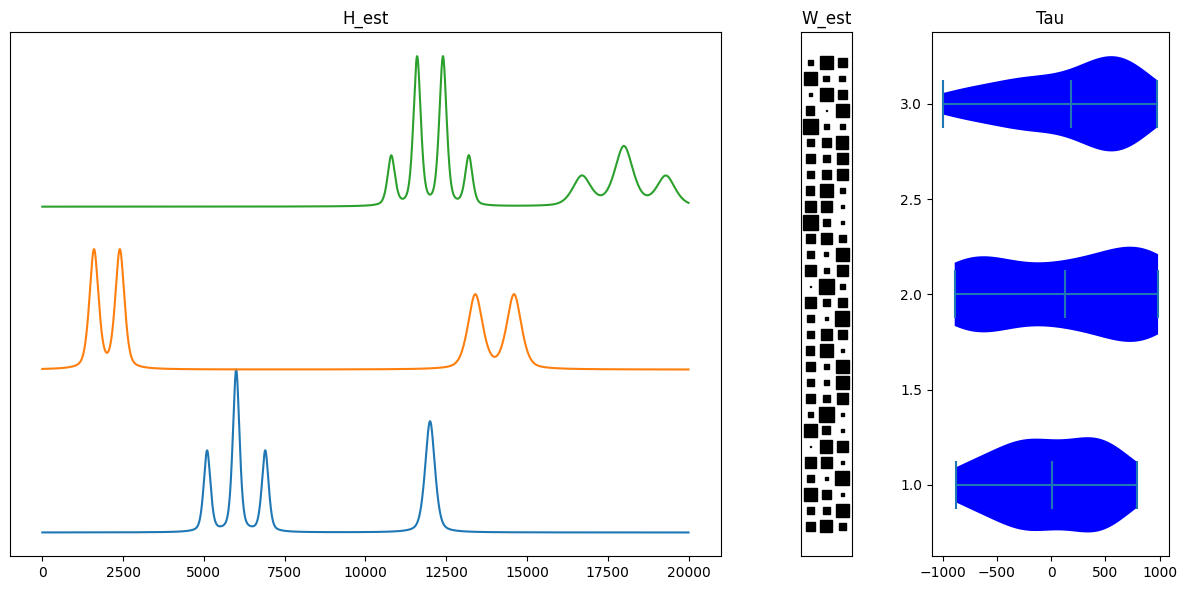

In [8]:
# Create a gridspec object with 2 rows and 3 columns
from helpers.plot import *
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(12, 6))
N, M = X_ART.shape

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, np.arange(H_ART.shape[1]), H_ART.T)
ax1.set_title('H_est')

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_ART.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(TAU_ART, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

# shiftNMF

epoch: 3000, Loss: 0.030678998987675933, Tau: 6589.5960422472035


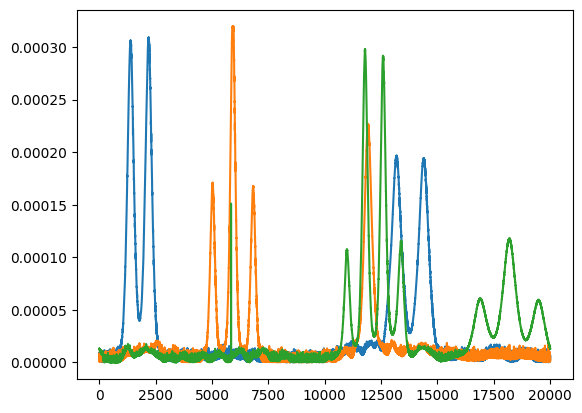

In [4]:
torch.manual_seed(3)

nmf = ShiftNMF(X_ART_NOISY, 3, lr=0.01, alpha=1e-4, patience=30, min_imp=0.001)
W_est, H_est, tau_est = nmf.fit(verbose=1, max_iter=2000, tau_iter=0)

plt.plot(H_est.T)
plt.show()
#0.022699544494929644
#0.06678218496574104

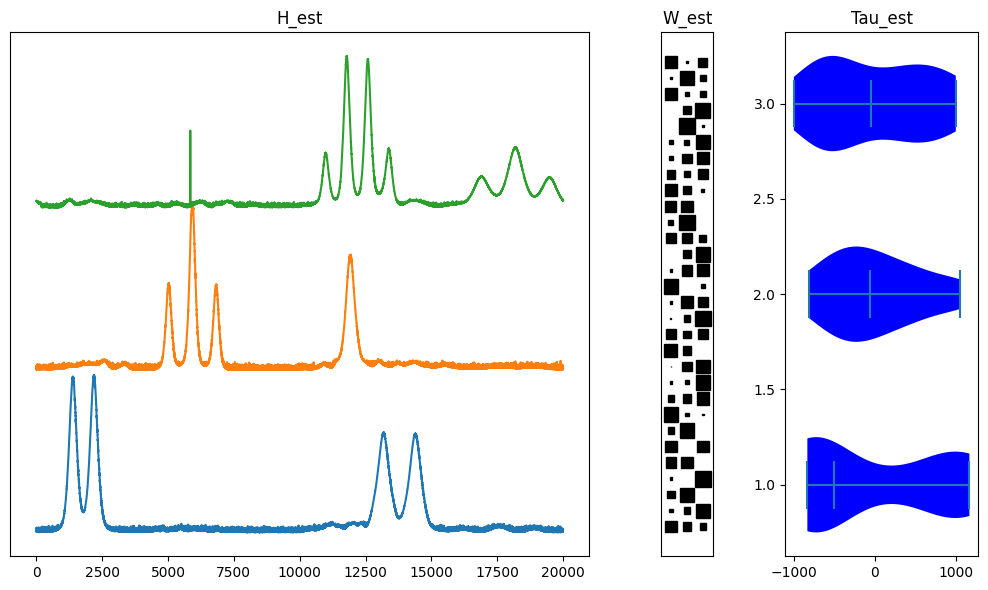

In [6]:
# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(10, 6))

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=False, showmedians=True, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*3)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

# peak finding (single fit)

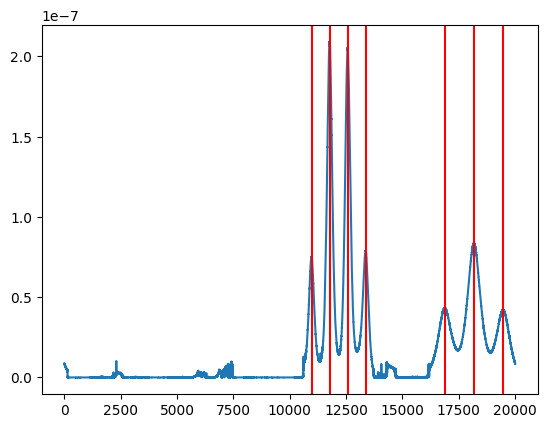

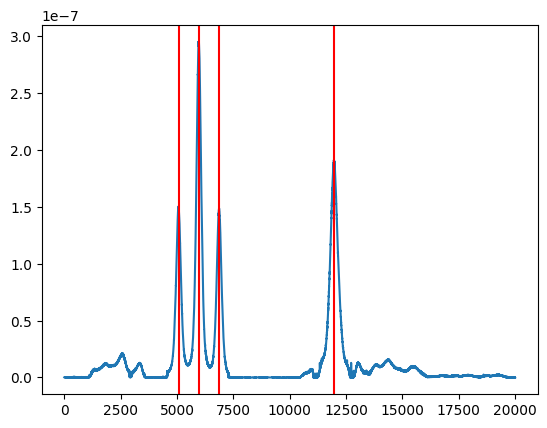

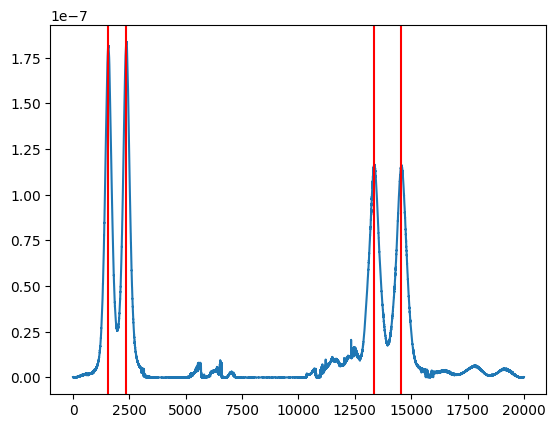

In [44]:

for i in range(len(H_est)):
    plt.plot(H_est[i])
    #peaks = find_peaks_cwt(H_est[i], [100,300])
    peaks = find_peaks(H_est[i], height=max(H_est[i])/10)[0]
    sigmas = scipy.signal.peak_widths(H_est[i], peaks, wlen=1000)[0]/2 #.355*1.5
    select = [sig>100 for sig in sigmas]
    select = [i for i, x in enumerate(select) if x == False]
    sigmas = np.delete(sigmas, select)
    peaks = np.delete(np.array(peaks), select)
    for mean in peaks:
        plt.axvline(mean, color='r')
    plt.show()

# Hardmodel

In [7]:
for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i])
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)
    W, C = hardmodel.fit(verbose=True, alpha=0.2)
    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5)

    for i, vec in enumerate(C):
        plt.plot(vec*W[:,i])
    plt.title("C weigthed")
    plt.show()

Found peaks:[ 1391  2192 13194 14392]
sigma: 141.14353769260887 n:0.060371532175243194
sigma: 143.89461218231375 n:6.853583212927848e-07
sigma: 223.02381753766485 n:0.12253309517130631
sigma: 224.93228179371184 n:4.967621250322067e-06
Lorentzian %:s: 0.016332478651220457
tensor([2.5321e-13, 4.1765e-09, 1.7914e-12, 4.1246e-09],
       grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([149.7290, 150.5166, 241.6802, 234.9839], requires_grad=True)
hypothesises:
{(0, 1), (1, 3), (2,), (1, 2), (0, 1, 2), (0, 1, 3), (0, 3), (0, 2, 3), (1, 2, 3), (2, 3), (1,), (0, 2), (0, 1, 2, 3), (0,), (3,)}

initial values:
means:
tensor([ 1791.5000, 13194.0000,  5592.3335,  5991.6665, 13793.0000,  2192.0000,
         7792.2500,  1391.0000, 14392.0000])
sigmas:
Parameter containing:
tensor([150.1228, 241.6802, 180.6420, 178.4099, 238.3320, 150.5166, 194.2274,
        149.7290, 234.9839], requires_grad=True)
spacing(J-coupling):
Parameter containing:
tensor([ 801.,    0.,  801.,  801., 1198.,  

TypeError: Hard_Model.fit() got an unexpected keyword argument 'alpha'